# Improved Naive Approach

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

### Imports

In [5]:
# Datascience libraries
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

# basic python libraries
import math
import time
from tqdm.notebook import tqdm as pb

# plot
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 16, 10

### Data

In [6]:
#Parser de fichiers
df = pd.read_csv("drive/My Drive/Colab Notebooks/data.txt",header=None)
M = df.values
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


In [7]:
def create_dist_matrix(M):
    dim = M.shape[0]
    dist_M = np.zeros((dim,dim))
    for i in pb(range(dim)):
        for j in range(dim):
            dist_M[i,j] = math.sqrt((M[i,1] - M[j,1])**2 + (M[i,2] - M[j,2])**2)
    return dist_M

## CSV Writter And Checker

In [10]:
def check_length_and_correctness(ids):
    print(len(ids))
    check_df = pd.DataFrame(ids)
    check_df = check_df[0].value_counts().values
    print("{}".format("correct" if len(check_df[check_df > 1]) == 0 else "some keys are present more than one time"))

In [11]:
def scatter_eaten(df, result):
    eatenP = {"eaten":'r',"alive":'b'}
    eaten = result[0]
    hue = []
    for id in df.loc[:,0]:
        if id in eaten:
            hue.append("eaten")
        else :
            hue.append("alive")

    fig = plt.figure()
    sns.scatterplot(x=df.iloc[:,1],y=df.iloc[:,2],s=0.5*df.iloc[:,3],
                    hue = hue, palette = eatenP)

In [12]:
def parser(ids, name):
    df = pd.DataFrame(ids)
    df.to_csv('{}.csv'.format(name), header=False, index=False)

## Objects

### Metrics

In [27]:
class Metric(object):
    def __init__(self):
        super(Metric, self).__init__()
        
    def apply(self, distances, rewards):
        return None
    
    def choose(self, distances, ratios, time_left):
        target_pos = np.argmax(ratios)
        if time_left - distances[target_pos] < 0:
            # the metrics can't find a cell to eat in the given left time
            return -1
        else:
            return target_pos
    
    # string representation of the object
    def __repr__(self):
        return "<Object : Metric (DataCamp)>"
    def __str__(self):
        return "Metric"

In [28]:
class Euclidean_4_Metric(Metric):
    def __init__(self):
        super(Euclidean_4_Metric, self).__init__()
        
    def choose(self, distances, rewards, time_left):
        pos = []
        values = []
        for i in range(distances.shape[0]):
            if distances[i] != 0. and rewards[i] != 0.:
                pos.append(i)
                values.append(distances[i])
        target_pos = np.argmin(np.array(values))
        if time_left - distances[pos[target_pos]] < 0:
            # the metrics can't find a cell to eat in the given left time
            return -1
        else:
            return pos[target_pos]

### Strategy

In [29]:
class Strategy(object):
    
    def __init__(self):
        super(Strategy, self).__init__()
    
    def choose_action(self, possibilities, rewards, time_left, coordinate):
        return None
        
    # string representation of the object
    def __repr__(self):
        return "<Object : Strategy (DataCamp)>"
    def __str__(self):
        return self.__repr__()

In [30]:
class Naive_Nearest_Strategy(Strategy):
    
    def __init__(self, metric):
        super(Naive_Nearest_Strategy, self).__init__()
        self.metric = metric
        
    def choose_action(self, distances, rewards, time_left, coordinate):
        action = self.metric.choose(distances, rewards, time_left)
        return action, distances[action]
        
    # string representation of the object
    def __repr__(self):
        return "<Object : Strategy (DataCamp) <> Naive_Nearest_Strategy>"
    def __str__(self):
        return self.__repr__()

### Game

In [31]:
class Game(object):
    
    def __init__(self, time, neigtbors):
        super(Game, self).__init__()
        self._const_time = time
        self.neigtbors = neigtbors
    
    # init a game and reset it
    def init_game(self, M, init_coord, init_dist):
        self._Values = M[:,1:]
        self._Ids = M[:, 0].astype(int)
        self.actual_coord = (init_coord[0], init_coord[1], -1)
        self.ids = []
        self.rewards = []
        self.time = 0.
        # first step
        return False, False, init_dist, self._Values[:,2], self._const_time - self.time, self.actual_coord
        
    # step in a game
    def step_env(self, action, distance):
        # check if there is a correct action or not
        if action == -1 or np.sum(self._Values[:,2]) == 0.:
            return True, False, None, None, self._const_time - self.time, None
        else:
            # get reward
            reward = self._Values[action, 2]
            self._Values[action, 2] = 0.

            # keep track of action
            self.ids.append(self._Ids[action])
            self.rewards.append(reward)

            # update time and coordinate
            self.time += distance
            self.actual_coord = (self._Values[action, 0], self._Values[action, 1], action)

            # step into the environnement
            if self.time < self._const_time:
                return False, False, self.neigtbors[self.actual_coord[2]], self._Values[:,2], self._const_time - self.time, self.actual_coord
            else:
                # previous time was not correctly endled by the agent(strategy)
                return False, True, None, None, self._const_time - self.time, None
    
        
    
    # string representation of the object
    def __repr__(self):
        return "<Object : Game (DataCamp) <> time:{}>".format(self._const_time)
    def __str__(self):
        return self.__repr__()

In [32]:
def play_game(game_, M, strategy, init_coord, init_distance, epochs=1):
    game = game_
    
    for _ in range(epochs):
        # reset env
        game_correctly_ended, game_bug_ended, possibilities, rewards, time_left, coordinates = game.init_game(M, init_coord, init_distance)
        _action = None
        # stepping in the environnement
        while((not game_correctly_ended) and (not game_bug_ended)):
            # the agent choose the following action
            action, distance = strategy.choose_action(possibilities, rewards, time_left, coordinates)
            if _action != None and _action == action:
                print("bug")
            # step
            game_correctly_ended, game_bug_ended, possibilities, rewards, time_left, coordinates = game.step_env(action, distance)
            _action=action
        #print("Time consumed :\n   > {}".format(game.time))
    return game.ids, sum(game.rewards)

## Applying Strategy

In [13]:
_max_time = 10_000.
_init_pos = (0,0)

In [14]:
init_distance = np.array([math.sqrt((_init_pos[0] - M[i, 1])**2+(_init_pos[1] - M[i, 2])**2) for i in range(M.shape[0])])
distances_M = create_dist_matrix(M)
distances_M.shape

(10000, 10000)

### Seek the best threshold

In [25]:
def reduced_best(M, distances_M, range_):
    results = []
    for i in pb(range_):
        indices = M[:,3] > i
        M_threshold = M[indices]
        distances = distances_M[indices][:,indices]
        init_distance = np.array([math.sqrt((_init_pos[0] - M_threshold[i, 1])**2+(_init_pos[1] - M_threshold[i, 2])**2) for i in range(M_threshold.shape[0])])
        strategy = Naive_Nearest_Strategy(Euclidean_4_Metric())
        result = play_game(Game(_max_time, np.copy(distances)), np.copy(M_threshold), strategy, _init_pos, init_distance)
        results.append(result[1])
    return results

In [34]:
res = reduced_best(M, distances_M, range(0,50))

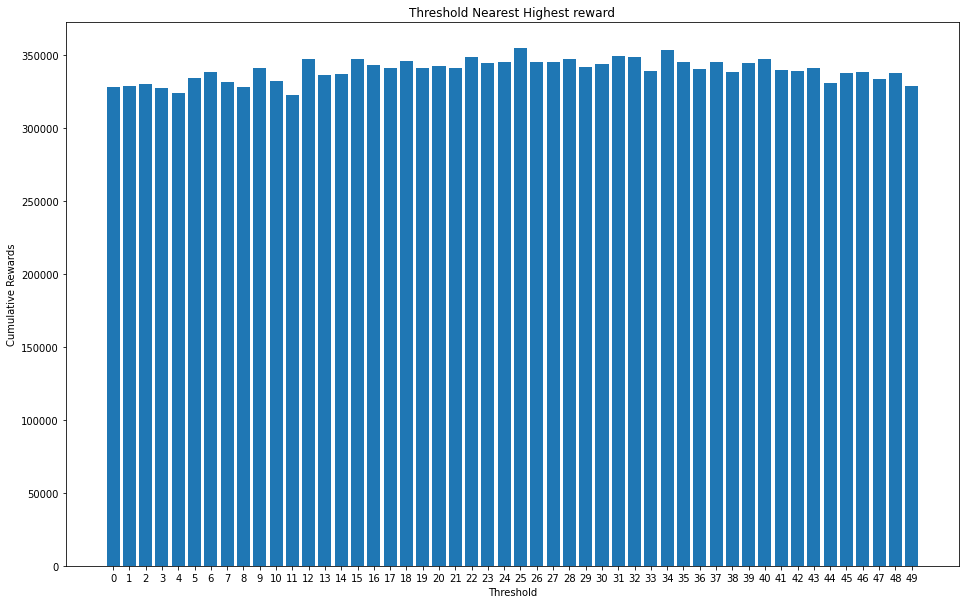

In [36]:
lon = list(range(0,50))
plt.bar(lon, res)
plt.title('Threshold Nearest Highest reward')
plt.xlabel('Threshold')
plt.ylabel('Cumulative Rewards')
plt.xticks(lon)
plt.show()

In [37]:
print(np.argmax(res), np.max(res))

25 354453.0


### Get the best threshold and apply it

In [38]:
threshold = np.argmax(res)

In [39]:
indices = M[:,3] > threshold
M_threshold = M[indices]
M_threshold.shape

(7497, 4)

In [40]:
distances = distances_M[indices][:,indices]
distances.shape

(7497, 7497)

In [41]:
init_distance = np.array([math.sqrt((_init_pos[0] - M_threshold[i, 1])**2+(_init_pos[1] - M_threshold[i, 2])**2) for i in range(M_threshold.shape[0])])

In [42]:
strategy = Naive_Nearest_Strategy(Euclidean_4_Metric())
result = play_game(Game(_max_time, np.copy(distances)), np.copy(M_threshold), strategy, _init_pos, init_distance)
print("Score :\n   > {}".format(result[1]))

Score :
   > 354453.0


In [43]:
check_length_and_correctness(result[0])

5646
correct


In [44]:
parser(result[0], "Euclidean_Threshold_Nearest_Metric")

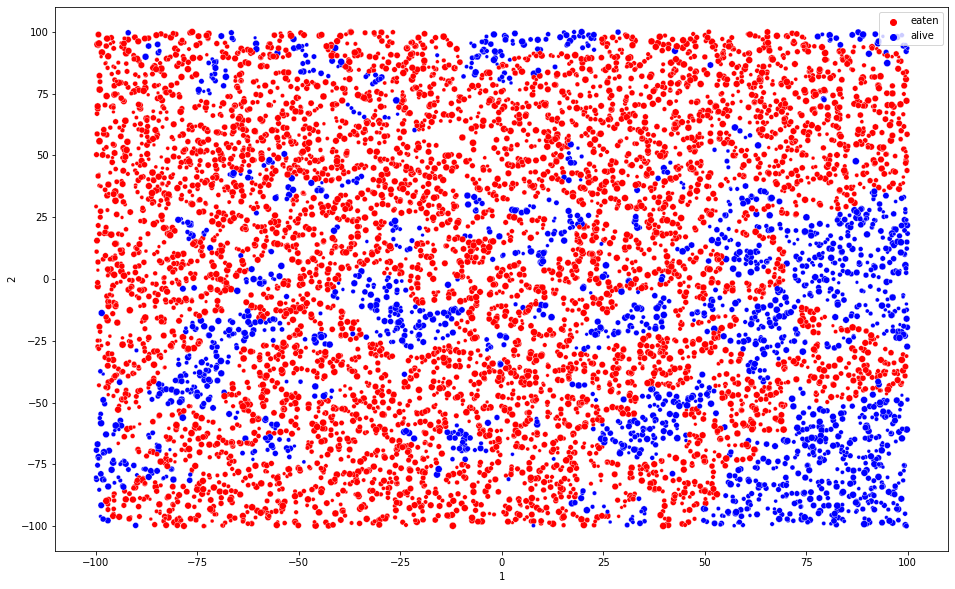

In [45]:
scatter_eaten(pd.DataFrame(M_threshold), result)